DUT-6


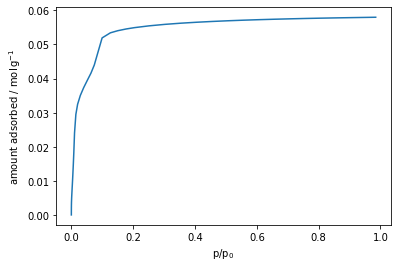

In [111]:
import numpy as np
from gemmi import cif
import matplotlib.pyplot as plt

aif = cif.read_file('database/DUT-6/nk_DUT-6_LP_N2_114pkt.aif')
block = aif.sole_block()
ads_press = np.array(block.find_loop('_adsorption_pressure'),dtype=float)
ads_amount = np.array(block.find_loop('_adsorption_amount'),dtype=float)
des_press = np.array(block.find_loop('_desorption_pressure'),dtype=float)
des_amount = np.array(block.find_loop('_desorption_amount'),dtype=float)

material_id = block.find_pair('_material_id')[-1]
material_mass = block.find_pair('_sample_mass')[-1]
print(material_id)

#convert to mmol/g to mol/g
ads_amount=ads_amount*0.001

#Ar properties
# p0 = 101.30*1000
# ads_cross = 0.142

#N2 properties
p0 = 101860.98004799998
ads_cross = 0.162

plt.plot(ads_press/p0,ads_amount)
plt.xlabel('p/p$_0$')
plt.ylabel('amount adsorbed / mol$\,$g$^{-1}$')
plt.show()


61


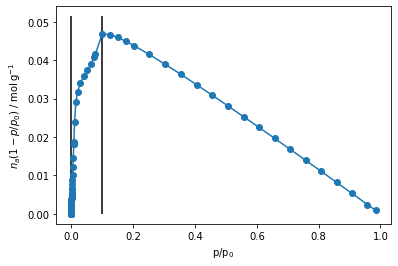

In [112]:
# apply 1st consistency criteria

pp0=ads_press/p0
roq_consistency = ads_amount*(1-pp0)

print(np.argmax(roq_consistency))

lo_limit = 0
hi_limit= np.argmax(roq_consistency)

plt.plot(pp0,roq_consistency, 'o-')
plt.xlabel('p/p$_0$')
plt.ylabel('$n_a(1-p/p_0)$ / mol$\,$g$^{-1}$')

plt.vlines(pp0[hi_limit],0,max(roq_consistency)*1.1)
plt.vlines(pp0[lo_limit],0,max(roq_consistency)*1.1)
plt.show()

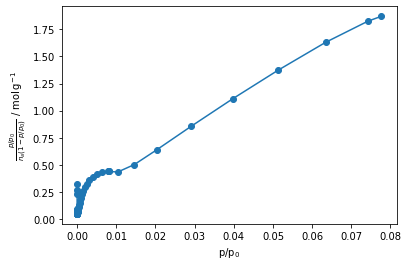

In [113]:
#transform to limits

pp0 =  pp0[lo_limit+1:hi_limit]
roq_consistency = roq_consistency[lo_limit+1:hi_limit]

#compute BET equation
BETeq = pp0/roq_consistency

plt.plot(pp0,BETeq,'o-')
plt.xlabel('p/p$_0$')
plt.ylabel(r'$\frac{p/p_0}{n_a(1-p/p_0)}$ / mol$\,$g$^{-1}$')

plt.show()

In [114]:
#fit slope and intercepts to a rolling 3 point window

from scipy.stats import linregress

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

BETeq_window = rolling_window(BETeq,3)
pp0_window = rolling_window(pp0,3)

output = []
for window in range(len(BETeq_window)):
    c=[]
    slope=[]
    intercept=[]
    fit = linregress(pp0_window[window],BETeq_window[window])
    slope = fit[0]
    intercept = fit[1]
    r2 = fit[2]
    c = 1+(slope/intercept)
    if c > 0 and r2>0.995:
        n_monolayer = 1/(intercept * c)
        p_monolayer = 1/(np.sqrt(c) + 1)
        BET_area = n_monolayer * ads_cross * (10**(-18)) * 6.022E23
        output.append([c,n_monolayer,p_monolayer,BET_area,np.min(pp0_window[window]),np.max(pp0_window[window]),np.mean(pp0_window[window])])

output=np.array(output)

print(output[:,3])

[  622.27221871   599.98162174   512.51045377   512.05184962
   534.27956865   539.4767082    549.05219664   539.45728756
   536.64347601   543.63848937   560.59662344   582.51868165
   613.75545221   654.11395816   766.9976964    849.31737624
   941.97353353  1111.74754436  1368.08337571  1739.68869538
  2261.26294201 21522.6345038   3984.84464591  4001.79284583
  4158.54312061  4403.18032188  4854.86986365  5516.38706735]


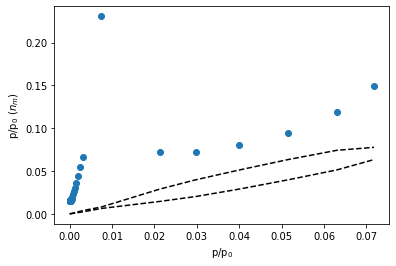

In [115]:
# plot p/p0 value corresponding to the monolayer capacity

plt.plot(output[:,-1],output[:,-2],'--',color='k')
plt.plot(output[:,-1],output[:,-3],'--',color='k')
plt.plot(output[:,-1],output[:,2], 'o')

plt.xlabel('p/p$_0$')
plt.ylabel('p/p$_0$ ($n_m$)')
plt.show()

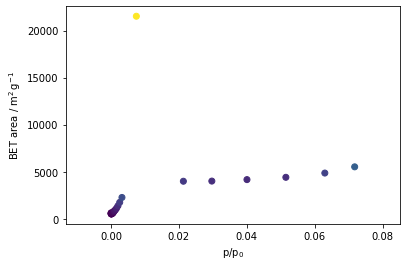

In [116]:
# plot variation of BET area

plt.scatter(output[:,-1],output[:,3], c=np.sqrt((output[:,-1]-output[:,2])**2))
plt.xlabel('p/p$_0$')
plt.ylabel('BET area / m$^2 \,$g$^{-1}$')
plt.show()
